# SegNet

This is a implementation of http://arxiv.org/pdf/1511.00561v2.pdf (Except for the Upsampling layer where paper uses indices based upsampling which is not implemented in keras yet( *I am working on it*), but that shouldnt make a lot of difference)


### Setting Theano Flags

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=gpu0,floatX=float32,optimizer=fast_compile,exception_verbosity=high'

In [2]:
from __future__ import absolute_import
from __future__ import print_function
import pylab as pl
import matplotlib.cm as cm
import itertools
import numpy as np
import theano.tensor as T
np.random.seed(1337) # for reproducibility

from keras.datasets import mnist
#import keras.layers.containers as containers
from keras.layers.noise import GaussianNoise
import keras.models as models
#import keras.layers.containers as containers
from keras.layers import Input
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Merge, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.regularizers import ActivityRegularizer

from keras import backend as K

import cv2
import numpy as np

path = './CamVid/'
data_shape = 360*480

/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


## Data Fetching 
I equalized histograms of rbg layers separately, so that change in lighting doesnt effect the results.

In [13]:
import numpy as np
import keras
import cv2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
def normalized(rgb):
    #return rgb/255.0
    norm=np.zeros((rgb.shape[0], rgb.shape[1], 3),np.float32)

    b=rgb[:,:,0]
    g=rgb[:,:,1]
    r=rgb[:,:,2]

    norm[:,:,0]=(b-np.mean(b))/np.std(b)
    norm[:,:,1]=(g-np.mean(g))/np.std(g)
    norm[:,:,2]=(r-np.mean(r))/np.std(r)

    return norm

def binarylab(labels):
    x = np.zeros([360,480,12])    
    for i in range(360):
        for j in range(480):
            x[i,j,labels[i][j]]=1
    return x

def prep_data():
    train_data = []
    train_label = []
    import os
    with open(path+'train.txt') as f:
        txt = f.readlines()
        txt = [line.split(' ') for line in txt]
    for i in range(len(txt)-200):
        ## these paths are very specific to my machine
        temp = np.zeros((12,360,480))
        train_data.append(np.rollaxis(normalized(cv2.imread(os.getcwd() + txt[i][0][7:])),2))
        temp[0,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,0]
        temp[1,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,1]
        temp[2,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,2]
        temp[3,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,3]
        temp[4,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,4]
        temp[5,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,5]
        temp[6,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,6]
        temp[7,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,7]
        temp[8,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,8]
        temp[9,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,9]
        temp[10,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,10]
        temp[11,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,11]
        train_label.append(temp)
        print('.',end='')
    return np.array(train_data), np.array(train_label)

train_data, train_label = prep_data()


.......................................................................................................................................................................

In [3]:
def normalized(rgb):
    #return rgb/255.0
    norm=np.zeros((rgb.shape[0], rgb.shape[1], 3),np.float32)

    b=rgb[:,:,0]
    g=rgb[:,:,1]
    r=rgb[:,:,2]

    norm[:,:,0]=(b-np.mean(b))/np.std(b)
    norm[:,:,1]=(g-np.mean(g))/np.std(g)
    norm[:,:,2]=(r-np.mean(r))/np.std(r)

    return norm

def binarylab(labels):
    x = np.zeros([360,480,12])
    for i in range(360):
        for j in range(480):
            x[i,j,labels[i][j]]=1
    return x

def prep_data():
    train_data = []
    train_label = []
    import os
    with open(path+'train.txt') as f:
        txt = f.readlines()
        txt = [line.split(' ') for line in txt]
    for i in range(len(txt)):
        train_data.append(np.rollaxis(normalized(cv2.imread(os.getcwd() + txt[i][0][7:])),2))
        train_label.append(binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0]))
        print('.',end='')
    return np.array(train_data), np.array(train_label)

train_data, train_label = prep_data()
train_label = np.reshape(train_label,(367,data_shape,12))

class_weighting= [0.2595, 0.1826, 4.5640, 0.1417, 0.5051, 0.3826, 9.6446, 1.8418, 6.6823, 6.2478, 3.0, 7.3614]

...............................................................................................................................................................................................................................................................................................................................................................................

In [4]:
train_label = np.reshape(train_label,(367,data_shape,12))
train_label.shape

(367, 172800, 12)

In [5]:

# class weigths
class_weighting= [0.2595, 0.1826, 4.5640, 0.1417, 0.9051, 0.3826, 9.6446, 1.8418, 6.6823, 6.2478, 3.0, 7.3614]


I am using custom Unpooling layer look here https://github.com/fchollet/keras/issues/1226 for the reason

In [6]:
class UnPooling2D(Layer):
    """A 2D Repeat layer"""
    def __init__(self, poolsize=(2, 2)):
        super(UnPooling2D, self).__init__()
        #self.input = T.tensor4()
        self.poolsize = poolsize

    @property
    def output_shape(self):
        input_shape = self.input_shape
        return (input_shape[0], input_shape[1],
                self.poolsize[0] * input_shape[2],
                self.poolsize[1] * input_shape[3])

    def get_output(self, train):
        X = self.get_input(train)
        s1 = self.poolsize[0]
        s2 = self.poolsize[1]
        output = X.repeat(s1, axis=2).repeat(s2, axis=3)
        return output

    def get_config(self):
        return {"name":self.__class__.__name__,
            "poolsize":self.poolsize}
    

### Creating and Compiling neuralnet

In [73]:
def create_encoding_layers():
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    return [
        ZeroPadding2D(padding=(pad,pad),input_shape=(3, 360, 480)),
        Convolution2D(filter_size, kernel, kernel, border_mode='valid', dim_ordering='th'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(128, kernel, kernel, border_mode='valid', dim_ordering='th'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(256, kernel, kernel, border_mode='valid', dim_ordering='th'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(512, kernel, kernel, border_mode='valid', dim_ordering='th'),
        BatchNormalization(),
        Activation('relu'),
        #MaxPooling2D(pool_size=(pool_size, pool_size)),
    ]

def create_decoding_layers():
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    return[
        #UpSampling2D(size=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(512, kernel, kernel, border_mode='valid', dim_ordering='th'),
        BatchNormalization(),

        UpSampling2D(size=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(256, kernel, kernel, border_mode='valid', dim_ordering='th'),
        BatchNormalization(),

        UpSampling2D(size=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(128, kernel, kernel, border_mode='valid', dim_ordering='th'),
        BatchNormalization(),

        UpSampling2D(size=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(filter_size, kernel, kernel, border_mode='valid', dim_ordering='th'),
        BatchNormalization(),
    ]

autoencoder = models.Sequential()
# Add a noise layer to get a denoising autoencoder. This helps avoid overfitting

#autoencoder.add(GaussianNoise(sigma=0.3))
autoencoder.encoding_layers = create_encoding_layers()
autoencoder.decoding_layers = create_decoding_layers()
for l in autoencoder.encoding_layers:
    autoencoder.add(l)
for l in autoencoder.decoding_layers:
    autoencoder.add(l)

autoencoder.add(Convolution2D(12, 1, 1, border_mode='valid', dim_ordering='th'))
#import ipdb; ipdb.set_trace()
#autoencoder.add(Reshape((12,360*480), input_shape=(12,360,480)))
#autoencoder.add(Permute((2, 1)))
autoencoder.add(Activation('sigmoid'))
#from keras.optimizers import SGD
#optimizer = SGD(lr=0.01, momentum=0.8, decay=0., nesterov=False)


#autoencoder.compile(loss="categorical_crossentropy", optimizer='adadelta')

In [6]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, UpSampling2D, Reshape, Permute, Input, merge
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Model
inputs = Input(((3,360,480)))
zeropad1 = ZeroPadding2D(padding=(1,1))(inputs)
conv1 = Convolution2D(64, 3, 3, border_mode='valid')(zeropad1)
batch1 = conv1#BatchNormalization(axis=1)(conv1)
act1 = Activation('relu')(batch1)
maxpool1 = MaxPooling2D(pool_size=(2,2))(act1) #64,204,220

zeropad2 = ZeroPadding2D(padding=(1,1))(maxpool1)
conv2 = Convolution2D(128, 3, 3, border_mode='valid')(zeropad2)
batch2 = conv2#BatchNormalization(axis=1)(conv2)
act2 = Activation('relu')(batch2)
maxpool2 = MaxPooling2D(pool_size=(2,2))(act2) #128,102,110

zeropad3 = ZeroPadding2D(padding=(1,1))(maxpool2)
conv3 = Convolution2D(256, 3, 3, border_mode='valid')(zeropad3)
batch3 = conv3#BatchNormalization(axis=1)(conv3)
act3 = Activation('relu')(batch3)
maxpool3 = MaxPooling2D(pool_size=(2,2))(act3) #256,51,55

zeropad4 = ZeroPadding2D(padding=(1,1))(maxpool3)
conv4 = Convolution2D(256, 3, 3, border_mode='valid')(zeropad4) #256,51,55
batch4 = conv4#BatchNormalization(axis=1)(conv4)

upsamp1 = merge([UpSampling2D(size=(2,2))(batch4), conv3], mode='concat', concat_axis=1)
zeropad5 = ZeroPadding2D(padding=(1,1))(upsamp1)
conv5 = Convolution2D(128, 3, 3, border_mode='valid')(zeropad5) #256,102,110
batch5 = conv5#BatchNormalization(axis=1)(conv5)

#upsamp2 = UpSampling2D(size=(2,2))(conv5)
upsamp2 = merge([UpSampling2D(size=(2,2))(batch5), conv2], mode='concat', concat_axis=1)
zeropad6 = ZeroPadding2D(padding=(1,1))(upsamp2)
conv6 = Convolution2D(128, 3, 3, border_mode='valid')(zeropad6)
batch6 = conv6#BatchNormalization(axis=1)(conv6)

upsamp3 = merge([UpSampling2D(size=(2,2))(batch6), conv1], mode='concat', concat_axis=1)
zeropad7 = ZeroPadding2D(padding=(1,1))(upsamp3)
conv7 = Convolution2D(64, 3, 3, border_mode='valid')(zeropad7)

conv8 = Convolution2D(12, 1, 1, border_mode='valid')(conv7)
reshape1 = Reshape((12,360*480))(conv8)
permute1 = Permute((2, 1))(reshape1)
finalact = Activation('softmax')(permute1)

modelcai = Model(input=inputs, output=finalact)

In [7]:
from keras.optimizers import SGD
from keras import backend as K
from keras.optimizers import Adam
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
sgd = SGD(lr=0.0001, momentum=1.5)
modelcai.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adadelta')
#modelcai.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

In [8]:
modelcai.layers[28].output_shape

(None, 12, 172800)

Visualizing autoencoder

## Training 
At the end of 100 epochs training acc was about 0.91

#### Epoch 100/100

367/367 [==============================] - 890s - loss: 0.2942 - acc: 0.9100   


In [41]:
modelcai.load_weights('weights_crossent_79pc')

In [11]:
nb_epoch = 10
batch_size = 5

modelcai.fit(train_data, train_label, batch_size=batch_size, nb_epoch=nb_epoch, verbose=True, class_weight=class_weighting, validation_split=0.2 )#, validation_data=(X_test, X_test))
#print history
#autoencoder.save_weights('model_weight_ep100.hdf5')

#score = autoencoder.evaluate(X_test, X_test, show_accuracy=True, verbose=0)
#print('Test score:', score[0])
#print('Test accuracy:', score[1]) 

Train on 293 samples, validate on 74 samples
Epoch 1/10
293/293 [==============================] - 174s - loss: 0.4252 - acc: 0.8613 - val_loss: 0.7251 - val_acc: 0.7938
Epoch 2/10
293/293 [==============================] - 174s - loss: 0.4148 - acc: 0.8648 - val_loss: 0.7653 - val_acc: 0.7936
Epoch 3/10
293/293 [==============================] - 173s - loss: 0.4242 - acc: 0.8633 - val_loss: 0.8126 - val_acc: 0.7466
Epoch 4/10
293/293 [==============================] - 173s - loss: 0.4392 - acc: 0.8582 - val_loss: 1.0010 - val_acc: 0.7314
Epoch 5/10
293/293 [==============================] - 173s - loss: 0.3783 - acc: 0.8763 - val_loss: 0.7156 - val_acc: 0.7831
Epoch 6/10
293/293 [==============================] - 173s - loss: 0.3746 - acc: 0.8773 - val_loss: 0.9827 - val_acc: 0.7185
Epoch 7/10
293/293 [==============================] - 173s - loss: 0.4005 - acc: 0.8695 - val_loss: 0.7204 - val_acc: 0.7914
Epoch 8/10
293/293 [==============================] - 173s - loss: 0.3843 - acc:

In [9]:
modelcai.save_weights('weights_normalizeddata_crossent_validerror_78pc')

### Visualization
I trained autoencoder sepeartely with 100 epochs, loading weights here.

In [60]:
autoencoder.load_weights('model_weight_ep100.hdf5')

NameError: name 'autoencoder' is not defined

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road_marking = [255,69,0]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

def visualize(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,11):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
    else:
        return rgb

In [13]:
import os

gt = []
with open(path+'train.txt') as f:
    txt = f.readlines()
    txt = [line.split(' ') for line in txt]
for i in range(len(txt)):
    gt.append(cv2.imread(os.getcwd() + txt[i][0][7:]))
#print(gt)

(1, 3, 360, 480)
(1, 172800, 12)
[5 0 5 ..., 3 3 3]
(360, 480, 3)


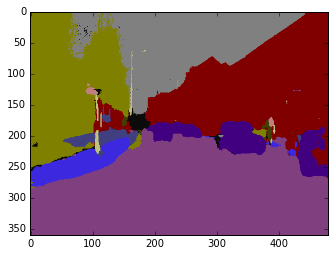

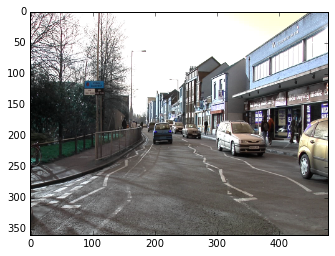

In [21]:
print(train_data[200:201].shape)
output = modelcai.predict(train_data[200:201])
print(output.shape)
print(np.argmax(output[0],axis=1))
pred = visualize(np.argmax(output[0],axis=1).reshape((360,480)), False)
print(pred.shape)
plt.imshow(pred)
plt.figure(2)
plt.imshow(gt[200])
plt.imsave('output.jpg',pred)
plt.imsave('input.jpg',gt[200])

(360, 480)


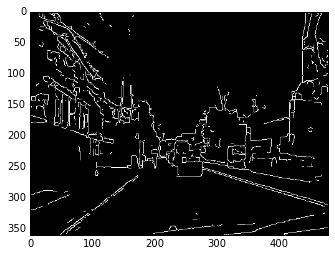

In [69]:
import cv2
img = gt[16]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
kernel = np.ones((5,5),np.uint8)
closing = cv2.morphologyEx(cv2.equalizeHist(gray), cv2.MORPH_OPEN, kernel)
print(gray.shape)
edges = cv2.Canny(closing,150,200)
edges_sobel = cv2.Sobel(closing,cv2.CV_8U,1,0,ksize=5)
plt.imshow(edges,cmap = 'gray')

In [1]:
run segnet.py

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


...............................................................................................................................................................................................................................................................................................................................................................................

/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/Keras-1.1.0-py2.7.egg/keras/engine/topology.py:1656: UserWarning: Model inputs must come from a Keras Input layer, they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to "sequential_1_model" was not an Input tensor, it was generated by layer layer_1.
Note that input tensors are instantiated via `tensor = Input(shape)`.
The tensor that caused the issue was: layer_input_1
  str(x.name))
/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/Keras-1.1.0-py2.7.egg/keras/models.py:603: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


KeyboardInterrupt: 

In [80]:
run segnet.py

...............................................................................................................................................................................................................................................................................................................................................................................Epoch 1/100


/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/Keras-1.1.0-py2.7.egg/keras/engine/topology.py:1656: UserWarning: Model inputs must come from a Keras Input layer, they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to "sequential_11_model" was not an Input tensor, it was generated by layer layer_3.
Note that input tensors are instantiated via `tensor = Input(shape)`.
The tensor that caused the issue was: layer_input_3
  str(x.name))


ValueError: Dimension 3 in Rebroadcast's input was supposed to be 1 (got 480 instead)
Apply node that caused the error: Rebroadcast{?,?,?,1}(GpuContiguous.0)
Toposort index: 359
Inputs types: [CudaNdarrayType(float32, (True, True, True, False))]
Inputs shapes: [(1, 1, 1, 480)]
Inputs strides: [(0, 0, 0, 1)]
Inputs values: ['not shown']
Outputs clients: [[GpuElemwise{true_div,no_inplace}(Rebroadcast{?,?,?,1}.0, GpuElemwise{sqrt,no_inplace}.0), GpuElemwise{Composite{((i0 * i1 * i2) / i3)},no_inplace}(CudaNdarrayConstant{[[[[-0.5]]]]}, GpuDimShuffle{x,0,x,x}.0, Rebroadcast{?,?,?,1}.0, GpuElemwise{mul,no_inplace}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/theano/gradient.py", line 1267, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/theano/gradient.py", line 961, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/theano/gradient.py", line 1267, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/theano/gradient.py", line 961, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/theano/gradient.py", line 1267, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/theano/gradient.py", line 961, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/theano/gradient.py", line 1267, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/theano/gradient.py", line 1101, in access_term_cache
    input_grads = node.op.grad(inputs, new_output_grads)
  File "/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/theano/gradient.py", line 1267, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/theano/gradient.py", line 961, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/theano/gradient.py", line 1267, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/theano/gradient.py", line 961, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/theano/gradient.py", line 1267, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/theano/gradient.py", line 961, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/theano/gradient.py", line 1267, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/theano/gradient.py", line 1101, in access_term_cache
    input_grads = node.op.grad(inputs, new_output_grads)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.